In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('../data/sales_train_evaluation.csv.zip')
cal = pd.read_csv('../data/calendar.csv', index_col=0)

In [60]:
df = pd.DataFrame()
tmp_df = pd.DataFrame()
tmp_df['target'] = [np.nan]*28
df['target'] = data.iloc[:,6:].sum().values
df = pd.concat([df,tmp_df])

In [62]:
# 特徴量エンジニアリング
for lag in [28,35,42,364]:
    df[f'lag_{lag}'] = df["target"].shift(lag)
    
for lag in [28,35,42,364]:
    for win in [7,14]:
        df[f'win{win}_lag{lag}'] = df['target'].transform(lambda x: x.shift(lag).rolling(win).mean())

In [63]:
train_df = df.iloc[:-56]
valid_df = df.iloc[-56:-28]
test_df = df.iloc[-28:]

In [64]:
trn_data = lgb.Dataset(train_df.drop('target',axis=1), 
                       label=train_df['target'])
val_data = lgb.Dataset(valid_df.drop('target',axis=1), 
                       label=valid_df['target'])

In [65]:
lgb_params = {
                'boosting_type': 'gbdt',
                'metric': 'rmse',
                'objective': 'regression',
                'seed': 127,
                'early_stopping_rounds' : 500,
                'learning_rate': 0.03
                } 

In [66]:
lgb_model = lgb.train(lgb_params,
                trn_data,
                num_boost_round = 10000,
                valid_sets = [trn_data, val_data],
                verbose_eval=500)

/home/zakopuro/anaconda3/envs/py37/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 1369.88	valid_1's rmse: 3554.81
[1000]	training's rmse: 936.037	valid_1's rmse: 3420.98
[1500]	training's rmse: 760.829	valid_1's rmse: 3400.03
[2000]	training's rmse: 688.95	valid_1's rmse: 3405.53
Early stopping, best iteration is:
[1674]	training's rmse: 728.326	valid_1's rmse: 3392.62


In [72]:
val_pred = lgb_model.predict(valid_df.drop('target',axis=1))
test_pred = lgb_model.predict(test_df.drop('target',axis=1))

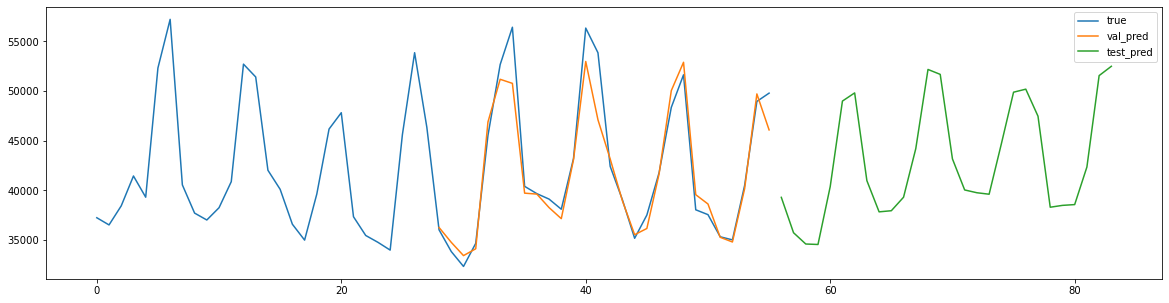

In [73]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0,56),train_df['target'][-56:],label='true')
plt.plot(np.arange(28,56),pred,label='val_pred')
plt.plot(np.arange(56,84),test_pred,label='test_pred')
plt.legend()
plt.show()

In [69]:
56+28

84